## Mount the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

organized_path = "/content/drive/MyDrive/EEG_ASZED_PROJECT/EEG_ASZED_ORGANIZED"


Mounted at /content/drive


### Checking if files exist

In [ ]:
import os

print("✅ Sample files:")
for f in os.listdir(organized_path)[:5]:
    print(f)

# Check labels.csv exists
print("✅ labels.csv found:", os.path.exists(os.path.join(organized_path, "labels.csv")))


✅ Sample files:
subj_subject_104_s1_Phase_3.edf
subj_subject_104_s1_Phase_1.edf
subj_subject_112_s2_Phase_2.edf
subj_subject_111_s3_Phase_4.edf
subj_subject_107_s2_Phase_2.edf
✅ labels.csv found: True


In [ ]:
!pip install mne


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 60.1 MB/s eta 0:00:00


# Generate Spectrogram Images for VGG16

In [ ]:
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Path setup
data_root = "/content/drive/MyDrive/EEG_ASZED_PROJECT/EEG_ASZED_ORGANIZED"
output_img_dir = "/content/drive/MyDrive/EEG_ASZED_PROJECT/EEG_IMAGES_VGG16"

# Create the output directory
os.makedirs(output_img_dir, exist_ok=True)

# Load metadata
labels_df = pd.read_csv(os.path.join(data_root, "labels.csv"))

# Spectrogram settings
fs = 128
n_fft = 256
n_overlap = 128

def save_spectrogram(data, save_path):
    plt.figure(figsize=(2.24, 2.24), dpi=100)
    plt.specgram(data, NFFT=n_fft, Fs=fs, noverlap=n_overlap, cmap="viridis")
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Generate spectrograms
for idx, row in tqdm(labels_df.iterrows(), total=len(labels_df)):
    edf_filename = row['filename']
    edf_path = os.path.join(data_root, edf_filename)
    save_filename = edf_filename.replace(".edf", ".png")
    save_path = os.path.join(output_img_dir, save_filename)

    try:
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        data, _ = raw[:19, :]  # Assume first 19 EEG channels
        signal = np.mean(data, axis=0)
        save_spectrogram(signal, save_path)
    except Exception as e:
        print(f"Error with {edf_filename}: {e}")


 33%|███▎      | 598/1801 [04:26<07:08,  2.81it/s]/tmp/ipython-input-5-3613685197.py:25: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=256).
  plt.specgram(data, NFFT=n_fft, Fs=fs, noverlap=n_overlap, cmap="viridis")
100%|██████████| 1801/1801 [12:51<00:00,  2.33it/s]


In [ ]:
import os
os.path.exists("/content/EEG_SPLIT")


False

## Create EEG_SPLIT (train, val, test)

In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split

# Corrected paths
base_dir = "/content/EEG_ASZED_PROJECT/EEG_ASZED_ORGANIZED"
spectrogram_dir = "/content/drive/MyDrive/EEG_ASZED_PROJECT/EEG_IMAGES_VGG16"
labels_csv_path = "/content/drive/MyDrive/EEG_ASZED_PROJECT/EEG_ASZED_ORGANIZED/labels.csv"
output_dir = "/content/EEG_SPLIT"

# Load labels
df = pd.read_csv(labels_csv_path)

# Group by subject_id to ensure no leakage across splits
subject_df = df.groupby("subject_id").first().reset_index()

# Stratified splitting
train_subjects, test_subjects = train_test_split(
    subject_df,
    test_size=0.3,
    stratify=subject_df["label"],
    random_state=42
)
val_subjects, test_subjects = train_test_split(
    test_subjects,
    test_size=0.5,
    stratify=test_subjects["label"],
    random_state=42
)

# Create a subject_id → split mapping
split_map = {}
for sid in train_subjects["subject_id"]:
    split_map[sid] = "train"
for sid in val_subjects["subject_id"]:
    split_map[sid] = "val"
for sid in test_subjects["subject_id"]:
    split_map[sid] = "test"

# Create folders
for split in ["train", "val", "test"]:
    for label in ["Control", "Patient"]:
        os.makedirs(os.path.join(output_dir, split, label), exist_ok=True)

# Corrected typo
copied = 0
for _, row in df.iterrows():
    sid = row["subject_id"]
    label = row["label"]
    filename = row["filename"].replace(".edf", ".png")
    split = split_map.get(sid)

    src = os.path.join(spectrogram_dir, filename)
    dst = os.path.join(output_dir, split, label, filename)

    if os.path.exists(src):
        shutil.copy2(src, dst)
        copied += 1

print(f"✅ Copied {copied} spectrogram images into split folders at: {output_dir}")


✅ Copied 1801 spectrogram images into split folders at: /content/EEG_SPLIT


# **VGG16 MODEL**

Found 1250 images belonging to 2 classes.
Found 290 images belonging to 2 classes.
Found 261 images belonging to 2 classes.
🛠️ Training new model...
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1049s 26s/step - accuracy: 0.5553 - loss: 0.7208 - val_accuracy: 0.8000 - val_loss: 0.4549 - learning_rate: 1.0000e-04
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1033s 26s/step - accuracy: 0.6980 - loss: 0.5238 - val_accuracy: 0.8276 - val_loss: 0.4414 - learning_rate: 1.0000e-04
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1046s 26s/step - accuracy: 0.7174 - loss: 0.4951 - val_accuracy: 0.8655 - val_loss: 0.3798 - learning_rate: 1.0000e-04
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1040s 26s/step - accuracy: 0.7332 - loss: 0.4929 - val_accuracy: 0.8690 - val_loss: 0.3596 - learning_rate: 1.0000e-04
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1024s 26s/step - accuracy: 0.7645 - loss: 0.4922 - val_accuracy: 0.8345 - val_loss: 0.3674 - learning_rate: 1.0000e-04
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1041s 26s/step - accuracy: 0.7800 - loss: 0.4723 - val_accuracy: 0.9103 - val_loss: 0.3581 - learning_rate: 1.0000e-04
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1076s 27s/step - acc

✅ Model saved to: /content/drive/MyDrive/EEG_ASZED_PROJECT/vgg16_eeg_model.h5
9/9 ━━━━━━━━━━━━━━━━━━━━ 189s 21s/step - accuracy: 0.6168 - loss: 0.6020
✅ Test Accuracy: 0.7625
9/9 ━━━━━━━━━━━━━━━━━━━━ 188s 21s/step

🧾 Classification Report:
              precision    recall  f1-score   support

     Control       1.00      0.52      0.68       129
     Patient       0.68      1.00      0.81       132

    accuracy                           0.76       261
   macro avg       0.84      0.76      0.75       261
weighted avg       0.84      0.76      0.75       261



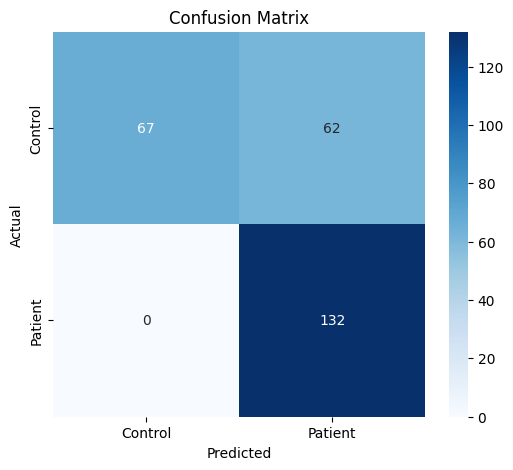

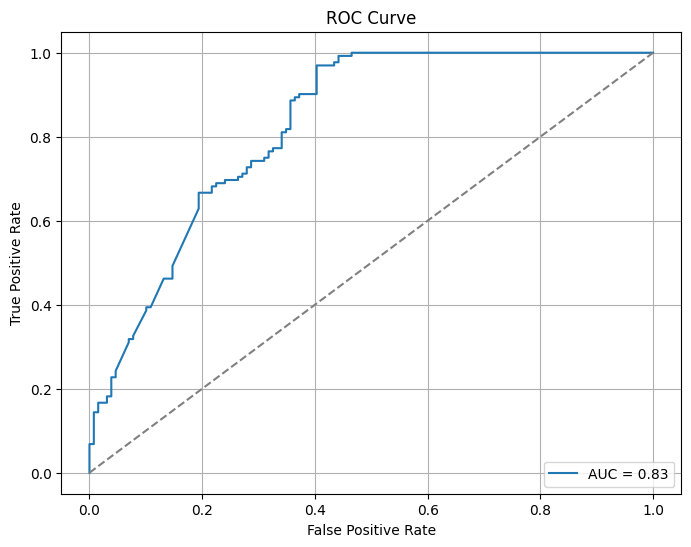

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Paths
data_dir = "/content/EEG_SPLIT"
model_path = "/content/drive/MyDrive/EEG_ASZED_PROJECT/vgg16_eeg_model.h5"
img_size = (224, 224)
batch_size = 32

# Data generators
train_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True, rotation_range=15).flow_from_directory(
    os.path.join(data_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

val_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(data_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary"
)

test_gen = ImageDataGenerator(rescale=1./255).flow_from_directory(
    os.path.join(data_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

# Class weights
labels = train_gen.classes
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))

# Load or train model
if os.path.exists(model_path):
    print("Loading existing model...")
    model = load_model(model_path)
else:
    print("Training new model...")
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    for layer in base_model.layers[:-4]:
        layer.trainable = False
    for layer in base_model.layers[-4:]:
        layer.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.5)(x)
    preds = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base_model.input, outputs=preds)
    model.compile(optimizer=Adam(1e-4), loss="binary_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(patience=5, restore_best_weights=True)
    lr_plateau = ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.5, verbose=1)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=15,
        callbacks=[early_stop, lr_plateau],
        class_weight=class_weights
    )

    model.save(model_path)
    print(f"✅ Model saved to: {model_path}")

# Evaluation
loss, acc = model.evaluate(test_gen)
print(f"✅ Test Accuracy: {acc:.4f}")

y_true = test_gen.classes
y_prob = model.predict(test_gen).flatten()
y_pred = (y_prob > 0.5).astype(int)

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))

# Confusion matrix heatmap
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices, yticklabels=test_gen.class_indices)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


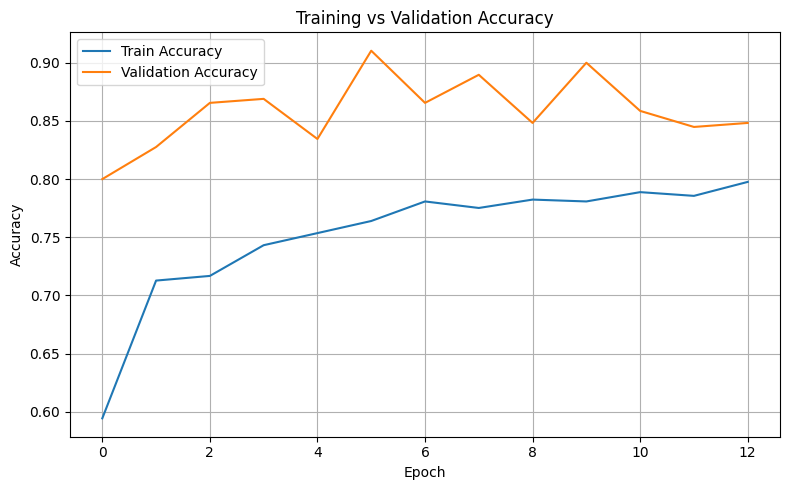

In [ ]:
# Plot accuracy curve
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
